In [1]:
%pylab inline
import tqdm
import pybinding as pb
from scipy.linalg import block_diag
from types import SimpleNamespace

Populating the interactive namespace from numpy and matplotlib


In [2]:
def surf_dos(u=-1.5,C=0.2,phi=0,L=100,W=40,num_pts=10,eran=linspace(-1,1,1000),broadening=0.01,show_tqdm=False):
    '''
    This function calculates local density of states on the edge of a coupled BHZ model.
    The considered geometry is a rectangle whose edge is at an angle phi with respect 
    to the underlying square lattice. 

    u = -1.5 # QWZ parameter
    C = 0.2  # BHZ coupling parameter
    phi=pi/2 # rotation angle
    L=100 # set aspect ratio of the rectangle
    W=40
    num_pts=10 # number of points to sample the edge
    eran=linspace(-1,1,1000) # energy range for the local dos calculations
    broadening=0.01 # energy broadening of LDOS calculation
    
    A SimpleNamespace object with all input parameters and also all relevant 
    calculated objects is returned.
    '''
    
    args=locals() # this is only a clever way to remember the input parameters
    # define pauli matrix
    sx = array([[0,1],
                [1,0]])
    sy = array([[0,-1j],
                [1j,0]])
    sz = array([[1,0],
                [0,-1]])

    # onsite and hopping terms defining the BHZ model with TRS^2=-1 coupling C
    U  = u*block_diag(sz,conj(sz))+C*kron(sy,sy)
    Tx = block_diag(sz+1.j*sx,conj(sz+1.j*sx))/2.
    Ty = block_diag(sz+1.j*sy,conj(sz+1.j*sy))/2.   
    
    # definition of the lattice to be a simple square lattice
    latt = pb.Lattice([1,0],[0,1])
    latt.add_one_sublattice('A',[0],U)
    latt.add_one_hopping([1,0],'A','A',Tx)
    latt.add_one_hopping([0,1],'A','A',Ty)
    
    # the sample will be a rotated rectangle cutted from a square lattice
    R=array([[cos(phi),-sin(phi)],
             [sin(phi),cos(phi)]])
    # define shape
    shape=pb.Polygon(
    (R@array([[L/2,L/2,-L/2,-L/2,L/2],
             [0  ,-W ,  -W,   0,  0]])).T
    )
    
    # build pybinding model
    model = pb.Model(latt,shape)
    # positions to calculate ldos 
    pts=R@array([linspace(-L/3,L/3,num_pts),zeros(num_pts)])
    # prepare kpm object
    kpm=pb.kpm(model,silent=True)

    # just an option to use or not to use tqdm
    pran=pts.T
    if show_tqdm:
        pran=tqdm.tqdm_notebook(pts.T)
    # we return a SimpleNamespace object with all input parameters and also all relevant 
    # calculated objects
    return SimpleNamespace(args=args,
                           model=model,
                           points=pts,
                           ldos_data=[kpm.calc_ldos(energy=eran,broadening=0.01,position=p) for p in pran ])

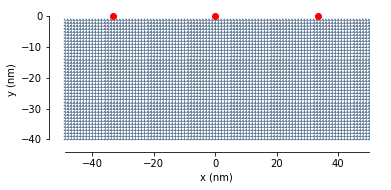

In [3]:
results=surf_dos(u=-1.4,C=0.001,num_pts=3,broadening=0.1)
results.model.plot()
plot(*results.points,'ro')

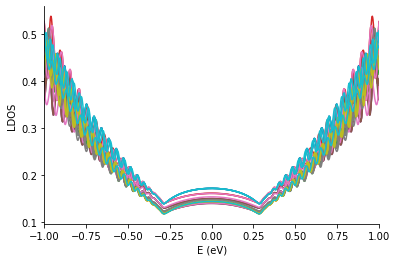

In [18]:
for i,p in enumerate(linspace(0,pi/2,10)):
    results=surf_dos(u=-1.7,C=0.1,num_pts=3,broadening=0.01,phi=p,L=500,W=50) 
#results.model.plot()
#plot(*results.points,'ro')
    [l.plot(color=f'C{i}') for l in results.ldos_data]